In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [69]:
#import
import numpy as np
import seaborn as sns # iris데이터
import pandas as pd   # 원핫인코딩
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자 -> 숫자)
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화

- iris 데이터
1. sepal_length : 꽃받침길이
2. sepal_width : 꽃받침넓이
3. petal_length : 꽃잎길이
4. petal_width : 꽃잎침넓이
5. species : 종(setosa,versicolor, virginical)

In [70]:
# 문자변수의 원핫인코딩
iris = sns.load_dataset('iris')
# to_categorical(iris['species'])
labelEncoder = LabelEncoder()
# labelEncoder.fit(iris['species'])
# iris['y'] = labelEncoder.transform(iris['species'])
iris['y'] = labelEncoder.fit_transform(iris.species) # 특수기호 없이 문자만 있으면 .으로 접근 가능
# iris.iloc[::25]
to_categorical(iris['y'])[::25] # to_categorical의 결과는 numpy 배열

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [71]:
# 문자변수 원핫인코딩 방법2
iris = sns.load_dataset('iris')
pd.get_dummies(iris.species).values # pd.get_dummies 결과는 데이터프레임. numpy배열로 변경해야함
pd.get_dummies(iris.species).to_numpy()[::25]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [72]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() # 결측치 있으면 결측치 처리
iris['species'].value_counts() # 타겟변수의 분포가 비슷해야함
# 독립변수와 타겟변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values # 머신러닝은 dataframe으로 넣으면 에러, numpy 배열로 변경
# iris_Y[::50]
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                   train_size=0.8,   # 훈련셋 비율
                                                 #  test_size=0.2,   # 테스트 비율
                                                 #  stratify=iris_Y, # 층화추출
                                                 #  random_state=7 # 랜덤 시드값
                                                   )
print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [73]:
# 층화추출이 되었는지 확인
print(pd.Series(np.argmax(iris_Y, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_train, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_test, axis=1)).value_counts())

0    50
1    50
2    50
dtype: int64
0    41
2    40
1    39
dtype: int64
1    11
2    10
0     9
dtype: int64


In [74]:
# 2. 모델구성(입력4, 출력3)
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax')) # 출력층
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                320       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 50)                6450      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_18 (Dense)            (None, 30)               

In [75]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# 4. 학습 : epoch마다 val_accuracy값이 좋아지고 있으면 model 자동 저장(콜백추가)
    # 모델 자동 저장될 경로 : ./model_iris/iris-004-val0.8745.h5
import os
model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델 자동 저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file, 
                             monitor='val_accuracy', # 모니터링 지표 (기본값:val_loss)
                             mode='max',
                             save_best_only=True, # 기본값은 False : 매번 저장
                             verbose=1 # 모델 저장시 로그 출력 (0: 로그출력안함)
                            )
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor 기본값은 val_loss
hist = model.fit(X_train, Y_train,
#                 batch_size=40, # 한번에 읽어들여 loss 계산하는 단위
                epochs=500,
                validation_split=0.2, # 훈련셋의 20%를 검증셋
                callbacks=[earlyStopping, checkpoint]
                )

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 1.3678 - accuracy: 0.3438
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./model_iris\iris-001-val0.3333.h5
3/3 [==============================] - 1s 99ms/step - loss: 1.2508 - accuracy: 0.3333 - val_loss: 1.0866 - val_accuracy: 0.3333
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.1344 - accuracy: 0.3125
Epoch 2: val_accuracy improved from 0.33333 to 0.58333, saving model to ./model_iris\iris-002-val0.5833.h5
3/3 [==============================] - 0s 31ms/step - loss: 1.0796 - accuracy: 0.3750 - val_loss: 1.0567 - val_accuracy: 0.5833
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0608 - accuracy: 0.4688
Epoch 3: val_accuracy did not improve from 0.58333
3/3 [==============================] - 0s 17ms/step - loss: 1.0208 - accuracy: 0.5625 - val_loss: 1.0250 - val_accuracy: 0.5833
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.9970 -

3/3 [==============================] - 0s 17ms/step - loss: 0.3420 - accuracy: 0.8542 - val_loss: 0.2675 - val_accuracy: 0.8750
Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4243 - accuracy: 0.7500
Epoch 30: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.3346 - accuracy: 0.8438 - val_loss: 0.1948 - val_accuracy: 0.9583
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3625 - accuracy: 0.8438
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.3182 - accuracy: 0.8750 - val_loss: 0.2197 - val_accuracy: 0.9583
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1444 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.2670 - accuracy: 0.9062 - val_loss: 0.2781 - val_accuracy: 0.8750
Epoch 33/500
1/3 [=========>....................] 

3/3 [==============================] - 0s 16ms/step - loss: 0.1223 - accuracy: 0.9583 - val_loss: 0.1821 - val_accuracy: 0.9167
Epoch 60/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3183 - accuracy: 0.8438
Epoch 60: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.2379 - accuracy: 0.8750 - val_loss: 0.1288 - val_accuracy: 0.9583
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3670 - accuracy: 0.8438
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.2561 - accuracy: 0.9062 - val_loss: 0.1124 - val_accuracy: 0.9583
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1101 - accuracy: 0.9688
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.1403 - accuracy: 0.9583 - val_loss: 0.1392 - val_accuracy: 0.9583
Epoch 63/500
1/3 [=========>....................] 

3/3 [==============================] - 0s 16ms/step - loss: 0.0916 - accuracy: 0.9792 - val_loss: 0.1431 - val_accuracy: 0.9583
Epoch 90/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1264 - accuracy: 0.9375
Epoch 90: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.1199 - accuracy: 0.9583 - val_loss: 0.1098 - val_accuracy: 0.9583
Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9688
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.1135 - accuracy: 0.9688 - val_loss: 0.1074 - val_accuracy: 0.9583
Epoch 92/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1465 - accuracy: 0.9375
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.1602 - accuracy: 0.9375 - val_loss: 0.1543 - val_accuracy: 0.9583
Epoch 93/500
1/3 [=========>....................] 

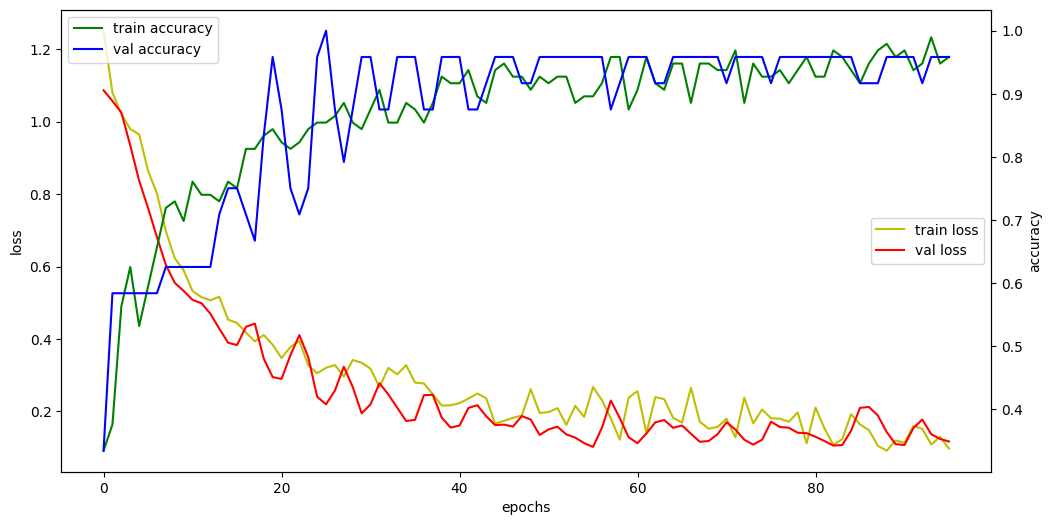

In [77]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [91]:
# 6. 모델 평가(evaluate:테스트셋, 교차표, recall, precision: y실제값, y예측값)
# iris-026-val1.0000.h5 모델도 같이 평가
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
# 학습된 모델
loss, acc = model.evaluate(X_test, Y_test)
loss, acc
# 모델의 recall과 precision을 위해서 실제값과 예측값
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test), axis=1)
recall = recall_score(real, pred, average='weighted') # average = 'weighted' : 다중분류
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model accuracy :', acc)
print('model recall :', recall)
print('model precision :', precision)
print('model f1 score :', f1)
print('model loss :', loss)
# 저장된 모델의 평가
model2 = load_model('model_iris/iris-026-val1.0000.h5')
loss, acc = model2.evaluate(X_test, Y_test)
pred = model2.predict(X_test).argmax(axis=1)
recall = recall_score(real, pred, average='weighted')
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model2 acc:', acc)
print('model2 recall:', recall)
print('model2 precision:', precision)
print('model2 f1:', f1)
print('model loss :', loss)

1/1 [==============================] - 0s 19ms/step
model accuracy : 1.0
model recall : 1.0
model precision : 1.0
model f1 score : 1.0
model loss : 0.017179805785417557
1/1 [==============================] - 0s 67ms/step
model2 acc: 1.0
model2 recall: 1.0
model2 precision: 1.0
model2 f1: 1.0
model loss : 0.16927748918533325


In [92]:
# 교차표
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
pd.crosstab(real, pred,
           rownames=['real'], colnames=['pred'])

pred,0,1,2
real,,,
0,9,0,0
1,0,11,0
2,0,0,10


In [ ]:
# 모델 저장 및 사용
save_model(model, 'model/iris.h5')
model.save('model/iris.h5') # tensorflow2.18 이상일 경우 확장자를 .keras로도 사용할 수 있음.

In [97]:
# 모델 예측하기
iris.loc[100].to_list() # [6.3, 3.3, 6.0, 2.5, 'virginica']
result = model.predict([[6.3, 3.3, 6.0, 2.5]]).argmax() # virginica
result

1/1 [==============================] - 0s 37ms/step


2